# Поскольку многозадачное обучение себя не очень хорошо показало, мы в дерьме. <br>
## Есть несколько вариантов решения этой проблемы. <br>
1. Можно использовать egemaps как информацию, внедряемую на один из скрытых слоев нейронки. Обязательно протестирую этот вариант чуть позже, поскольку следующий вариант гораздо проще в реализации. 
2. В своих моделях я использовал одноканальное изображение. Есть следующая стратегия улучшения: делаем из одноканального изображения трехканальное: первый канал - спектрограмма, второй - первая производная, третий - вторая производная. Подход реализуемый за час времени, подход используемый (видел пару статей в которых это применялось, однако там была трехмерная свертка)

### Пробую поиграться со вторым подходом. <br>
Код модуля iemocap.py был изменен, в класс IemocapDataset был добавлен параметр channels=(grayscale | rgb | delta): <br>
grayscale: обычное одноканальное изображение, параметр по умолчанию <br>
rgb: трехканальное изображение, получаемое путем копирования одного канала в два других <br>
delta: в первом канале спектрограмма, во втором и третьем - первая и вторая производные 

In [1]:
from datasets.iemocap import IemocapDataset
import numpy as np
import cv2
import librosa.display
import matplotlib.pyplot as plt
from constants import *
import torch

In [2]:
class UnNormalize(object):  # Этот класс нужен, чтобы адекватно отображать изображения в imshow()
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unnorm = UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#### По умолчанию изображения одноканальные:

In [3]:
iemocap = IemocapDataset(  # Без препроцессинга, тренировочный, аугментация включена
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=False, 
    augmentation=True, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion', 
    channels='grayscale'
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_224_train ===============
=========================== SUCCESS! ====================================


(1, 224, 224)


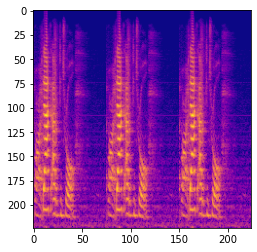

In [4]:
img, labels = iemocap[3]
img = unnorm(img)
img = img.numpy()
print(img.shape)
img = np.squeeze(img, axis=0)
imgplot = plt.imshow(img, cmap='plasma')

#### Пробуем отобразить трехканальное изображение:

============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_224_train ===============
=========================== SUCCESS! ====================================
(224, 224, 3)


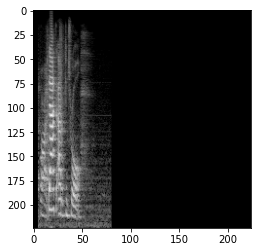

In [6]:
iemocap_rgb = IemocapDataset(  # Без препроцессинга, тренировочный, аугментация включена
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=False, 
    augmentation=True, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion', 
    channels='rgb'
)
img, labels = iemocap_rgb[3]
img = unnorm(img)
img = img.permute(1, 2, 0)  # Для imshow() каналы должны быть в последнем измерении
img = img.numpy()
print(img.shape)
imgplot = plt.imshow(img)

#### Пробуем отобразить третий вариант

============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_224_test ===============
=========================== SUCCESS! ====================================
(224, 224, 3)


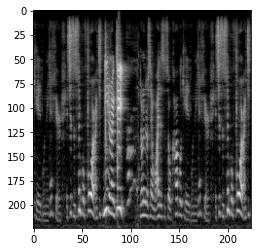

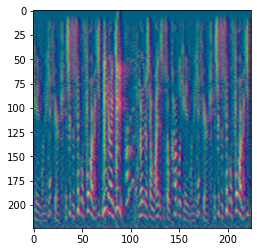

In [13]:
iemocap_rgb = IemocapDataset(  # Без препроцессинга, тренировочный, аугментация включена
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=True, 
    augmentation=True, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion', 
    channels='rgb'
)
img, labels = iemocap_rgb[1]
img = unnorm(img)
img = img.permute(1, 2, 0)  # Для imshow() каналы должны быть в последнем измерении
img = img.numpy()
print(img.shape)
imgplot = plt.imshow(img)
plt.show()
iemocap_rgb.channels = 'delta'
img, labels = iemocap_rgb[1]
img = unnorm(img)
img = img.permute(1, 2, 0)  # Для imshow() каналы должны быть в последнем измерении
img = img.numpy()
imgplot = plt.imshow(img)
plt.show()

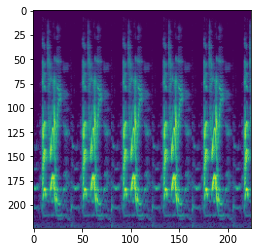

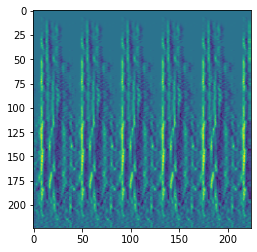

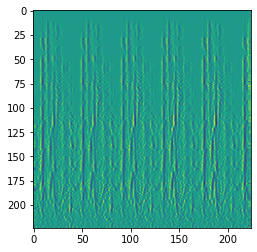

In [10]:
spec, delta, delta2 = cv2.split(img)
plt.imshow(spec)
plt.show()
plt.imshow(delta)
plt.show()
plt.imshow(delta2)
plt.show()